### Numpy-имплементация многослойной нейронной сети

**Разработчик: Артём Бабенко**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mryab/dl-hse-ami/blob/master/week01_intro/homework.ipynb)


В этом задании необходимо будет самостоятельно реализовать нейронную сеть и обучить ее с помощью метода обратного распространения ошибки.

In [1]:
import numpy as np

In [2]:
# Load dependencies
!wget --quiet --show-progress "https://raw.githubusercontent.com/mryab/dl-hse-ami/master/week01_intro/util.py"

util.py             100%[===================>]   3,97K  --.-KB/s    in 0s      


Сначала определим базовый класс Layer с основными методами .forward() и .backward().

In [2]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)

    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # An identity layer does nothing
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.

        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):

        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.

        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = input.shape[1]

        d_layer_d_input = np.eye(input_dim)

        return np.dot(grad_output, d_layer_d_input) # chain rule

### Дальнейший план

В этом задании необходимо построить нейросеть для классификации рукописных цифр. Для этого понадобится реализовать следующее:
- ReLU слой
- Полносвязный слой, $f(X)=W \cdot X + b$
- Функцию потерь, для задачи классификации - cross-entropy
- Алгоритм обратного распространения ошибки

Далее вам необходимо будет реализовать каждый из пунктов выше, пользуяюсь предоставленными сниппетами кода.


### ReLU слой
В этом слое применяется поэлементная нелинейность $f(X)=max(X,0)$. В этом слое необходимо реализовать только .forward() метод.

In [3]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass

    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        output = np.maximum(input,0)
        return output

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad_mask = input > 0
        return grad_output * relu_grad_mask

Для отладки градиентов, вычисленных аналитически, рекомендуется использовать сравнение с градиентами, вычисленными численно, как рассказывалось на лекции. Если вы корректно реализовали методы .forward() и .backward(), то значения градиентов окажутся достаточно близкими. Функция численного подсчета градиентов уже реализована в файле util.py

In [4]:
# some tests
from util import eval_numerical_gradient
points = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(points, np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=points)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

### Полносвязный слой

У полносвязного слоя есть обучаемые параметры: матрица линейного преобразования и столбец свободных членов.

$$f(X)= W \cdot X + b $$

* X - матрица входных данных размера [batch_size, num_features],
* W - матрица преобразования размера [num_features, num_outputs]
* b - столбец свободных членов размера [num_outputs]

W и b необходимо инициализировать во время создания слоя и обновлять при каждом вызове метода .backward().
Для этого слоя вам необходимо реализовать как прямой, так и обратный проход. Формулы для аналитического подсчета градиентов можно взять из лекции, но рекомендуется проверить их самостоятельно на бумаге.

In [5]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate

        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)

    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b

        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return input @ self.weights + self.biases

    def backward(self,input,grad_output):

        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = grad_output @ self.weights.T

        # compute gradient w.r.t. weights and biases
        grad_weights = input.T @ grad_output
        grad_biases = grad_output.sum(axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

### Тестирование полносвязного слоя

Три следующих блока тестируют вашу реализацию, если все корректно, вы трижды получите "Well done!"

In [6]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [7]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [8]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)

def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases

w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### Функция потерь

Вычисление функции потерь для задачи классификации, а также ее градиента уже сделано для вас.

In [9]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]

    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

In [10]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Итоговая нейросеть

Все готово для запуска нейросети. Нейросеть будем тестировать на классическом датасете MNIST. Код ниже визуализирует несколько примеров из этого датасета.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# doesnt work as yann.lecun site returns 403 and have cert expired
# from util import load_mnist
# X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

from sklearn.datasets import fetch_openml
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

/usr/lib/python3/dist-packages/sklearn/datasets/_openml.py:935: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [12]:
print (X.shape, y.shape)

(70000, 784) (70000,)


In [13]:
y = y.astype(np.int64)
print(y[2:5])

[4 1 9]


In [14]:
X_train, X_val, X_test = X[:50000], X[50000:60000], X[60000:]
y_train, y_val, y_test = y[:50000], y[50000:60000], y[60000:]

X_train = X_train.reshape([X_train.shape[0], -1])
X_val = X_val.reshape([X_val.shape[0], -1])
X_test = X_test.reshape([X_test.shape[0], -1])

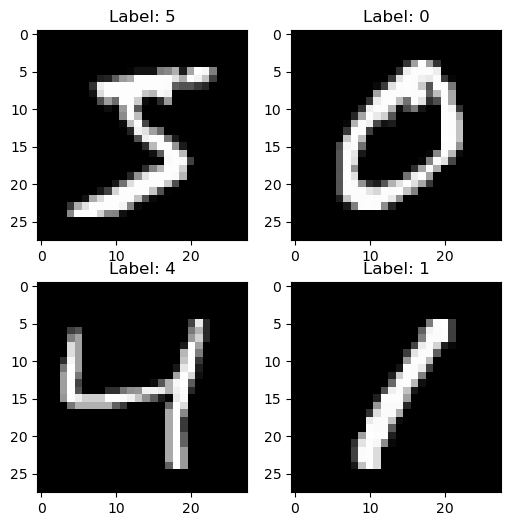

In [15]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %s"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

В нашей реализации сеть - просто список (Python-list) слоев.

In [22]:
network = []
hidden_layers_size = 40
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))

Реализуйте прямой проход по целой сети, последовательно вызывая .forward() для каждого слоя.

In [17]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer.
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:
        activations.append(layer.forward(input))
        input = activations[-1]

    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

In [18]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.

    After you called backward for all layers, all Dense layers have already made one gradient step.
    """

    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]

    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    for i in reversed(range(len(network))):
        loss_grad = network[i].backward(layer_inputs[i], loss_grad)
    

    return np.mean(loss)

Все готово для запуска обучения. Если все реализовано корректно, то точность классификации на валидационном множестве должна превысить 97%.

In [19]:
from tqdm.auto import tqdm
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [23]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 14
Train accuracy: 0.11424
Val accuracy: 0.1069


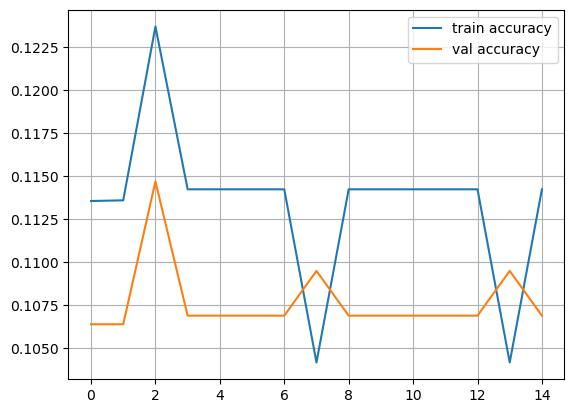

In [24]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)

    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


In [57]:
print(train_log)

[0.09864, 0.09864, 0.09864, 0.09864, 0.09864, 0.09864, 0.09864, 0.09864, 0.09864, 0.09864, 0.09864, 0.09864, 0.09864, 0.09864, 0.09864]


## Нейросеть для извлечения представлений
Помимо собственно классификации, нейросети часто используют для получения векторных описаний (embeddings) объектов различной природы. Часто в качестве представлений можно взять просто векторы активаций нейронов с одного из последних слоев. Вычислим такие представления:

In [ ]:
train_activations = forward(network, X_train)
train_hidden_representations = train_activations[2]
test_activations = forward(network, X_test)
test_hidden_representations = test_activations[2]

Полученные представления можно использовать в любых целях, в комбинации с другими инструментами машинного обучения.
Сравним обученные представления для изображений из MNIST c исходными 784-мерными представлениями. Постройте t-SNE визуализации 1000 случайных изображений из X_train, полученные на основе исходных 784-мерных представлений и обученных представлений. Сделайте вывод о качестве представлений.

In [ ]:
from util import plot_embedding
from sklearn.manifold import TSNE
subset_ids = np.random.permutation(X_train.shape[0])[:1000]
#x_original_tsne = <your code>
#x_learnt_tsne = <your code>

In [ ]:
plot_embedding(x_original_tsne, y_train[subset_ids])

In [ ]:
plot_embedding(x_learnt_tsne, y_train[subset_ids])

Наконец, исследуем универсальность полученных представлений. Используем их для решения другой задачи классификации: предсказание четности изображенной цифры.

In [ ]:
new_y_train = y_train % 2
new_y_test = y_test % 2

Обучите простейшую логистическую регресиию, предсказывающую четность изображенной цифры, используя в качестве вектора признаков:

1) исходные 784-мерные представления

2) обученные представления

Сравните качество и сделайте вывод об универсальности обученных представлений.

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver="lbfgs")
#<your code>
